In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.layers import Flatten, Dot, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split
import pickle

# 주간 수익률 데이터를 읽어온다.
rtn_df = pd.read_csv('49_Industry_Portfolios_Daily_Value_logreturn.csv', index_col=0)
rtn_R = np.array(rtn_df)

N_FACTORS = 10    # number of factors
N_ROW = rtn_R.shape[0]    # time 개수
N_COL = rtn_R.shape[1]    # item (종목) 개수
print("Factor : ", N_FACTORS)
print("N_ROW : ", N_ROW)
print("N_COL : ", N_COL)

Factor :  10
N_ROW :  1727
N_COL :  49


In [41]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [42]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2946302843467849553
xla_global_id: -1
]


In [44]:
from keras import backend as K
K._get_available_gpus()

[]

In [27]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
    
import tensorboard
tensorboard.__version__

from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format("F-B_Network_model_log"))

TensorFlow version:  2.11.0


In [31]:
# mean centering
E = rtn_R.mean(axis=0).reshape(1, N_COL)
cent_R = rtn_R - E

# unpivoting
R = pd.DataFrame(cent_R).stack().reset_index()
R.columns = ['row', 'col', 'rtn']

# 데이터 세트를 생성한다.
x_row = np.array(R['row']).astype('int').reshape(-1, 1)
x_col = np.array(R['col']).astype('int').reshape(-1, 1)
y_rtn = np.array(R['rtn']).reshape(-1, 1)

# 학습 데이터와 시험 데이터를 생성한다.
x_train_row, x_test_row, x_train_col, x_test_col, y_train, y_test = \
                    train_test_split(x_row, x_col, y_rtn, test_size = 0.1)

# 행렬분해 네트워크
x_input_row = Input(batch_shape = (None, x_row.shape[1]))
x_input_col = Input(batch_shape = (None, x_col.shape[1]))

# F-네트워크
x_row_emb = Embedding(N_ROW, 800, name='F')(x_input_row) # 기존 1727 -> 10 레이어
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(800, activation='relu')(x_row_emb)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(400, activation='relu')(x_row_emb)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(256, activation='relu')(x_row_emb)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(128, activation='relu')(x_row_emb)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(64, activation='relu')(x_row_emb)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(32, activation='relu')(x_row_emb)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Dense(16, activation='relu')(x_row_emb)
x_row_emb = Dense(N_FACTORS, activation='relu')(x_row_emb)
x_row_emb = Flatten()(x_row_emb)

# B-네트워크
x_col_emb = Embedding(N_COL, 24, name='B')(x_input_col) # 기존 49 -> 10 레이어
x_col_emb = Dropout(0.2)(x_col_emb)
x_col_emb = Dense(24, activation='relu')(x_col_emb)
x_col_emb = Dropout(0.2)(x_col_emb)
x_col_emb = Dense(16, activation='relu')(x_col_emb)
x_col_emb = Dense(N_FACTORS, activation='relu')(x_col_emb)
x_col_emb = Flatten()(x_col_emb)

# 추정 수익률 계산
y_output = Dot(axes=1)([x_row_emb, x_col_emb])
model = Model([x_input_row, x_input_col], y_output)
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0005))

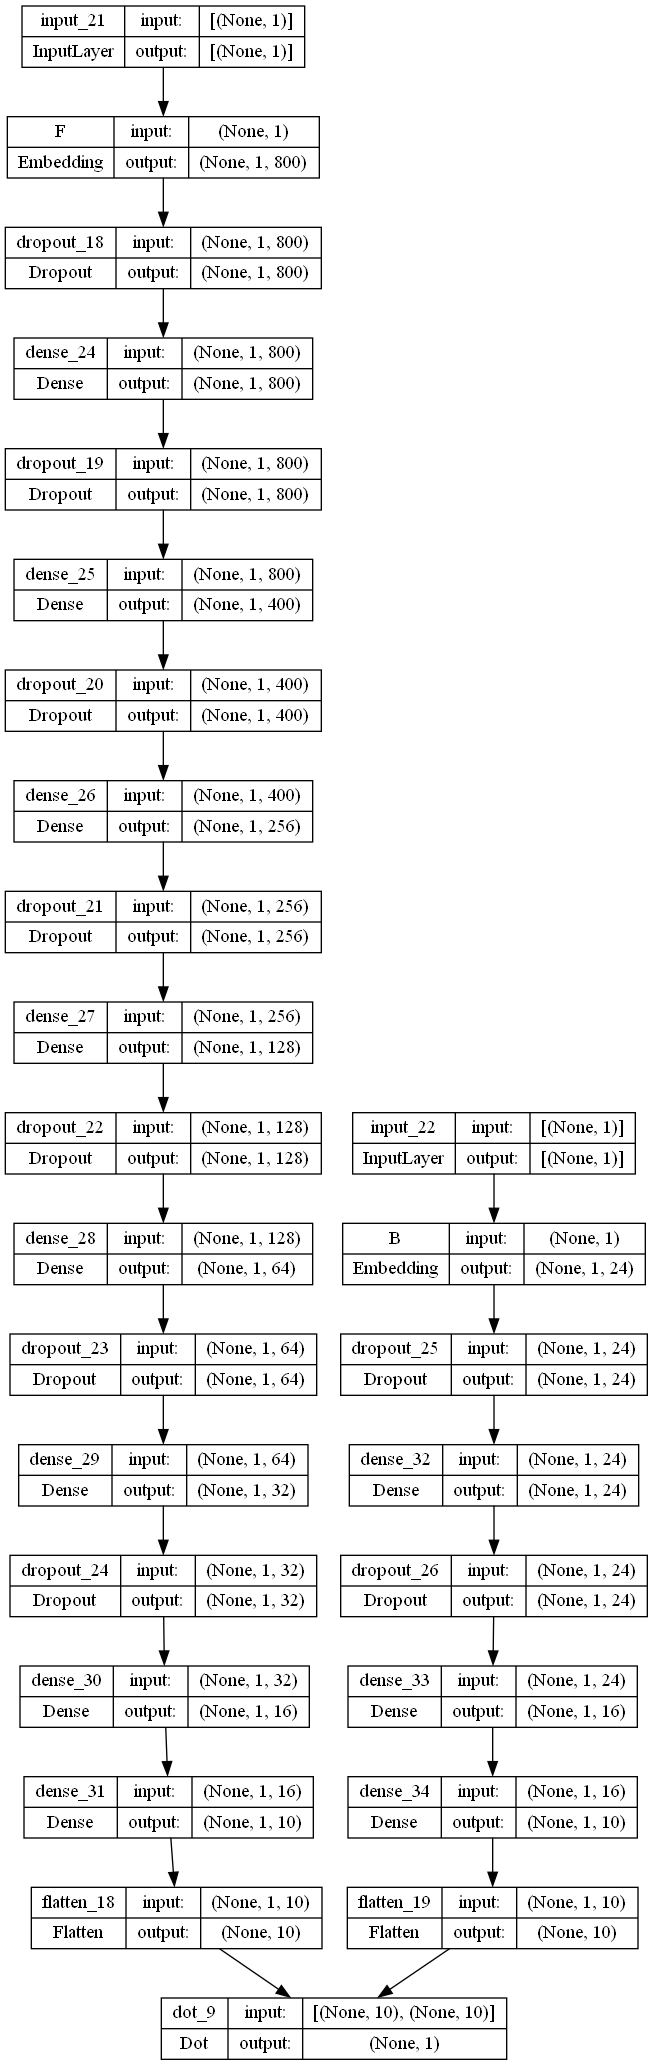

In [32]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [45]:
# 학습
hist = model.fit([x_train_row, x_train_col], y_train, 
                  validation_data = ([x_test_row, x_test_col], y_test),
                  batch_size = 256, epochs = 100, callbacks=[tensorboard])

# loss history
plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.legend()
plt.show()

Epoch 1/100
298/298 [==============================] - 8s 25ms/step - loss: 9.3069e-04 - val_loss: 9.4455e-04
Epoch 2/100
284/298 [===========================>..] - ETA: 0s - loss: 9.3468e-04

KeyboardInterrupt: 

In [ ]:
# 행렬 F, B
F = model.get_layer('F').get_weights()[0]
B = model.get_layer('B').get_weights()[0]

# F, B로 추정한 주가와 실제 주가 차트를 비교한다.
sym2idx = {k:v for v, k in enumerate(list(rtn_df.columns))}
idx2sym = {v:k for k, v in sym2idx.items()}

rtn_EFB = E + np.dot(F, B.T)  # 추정된 수익률
def calc_price(r):
    prc = [1.0]
    for i in r:
        prc.append(prc[-1] * np.exp(i))
    return prc

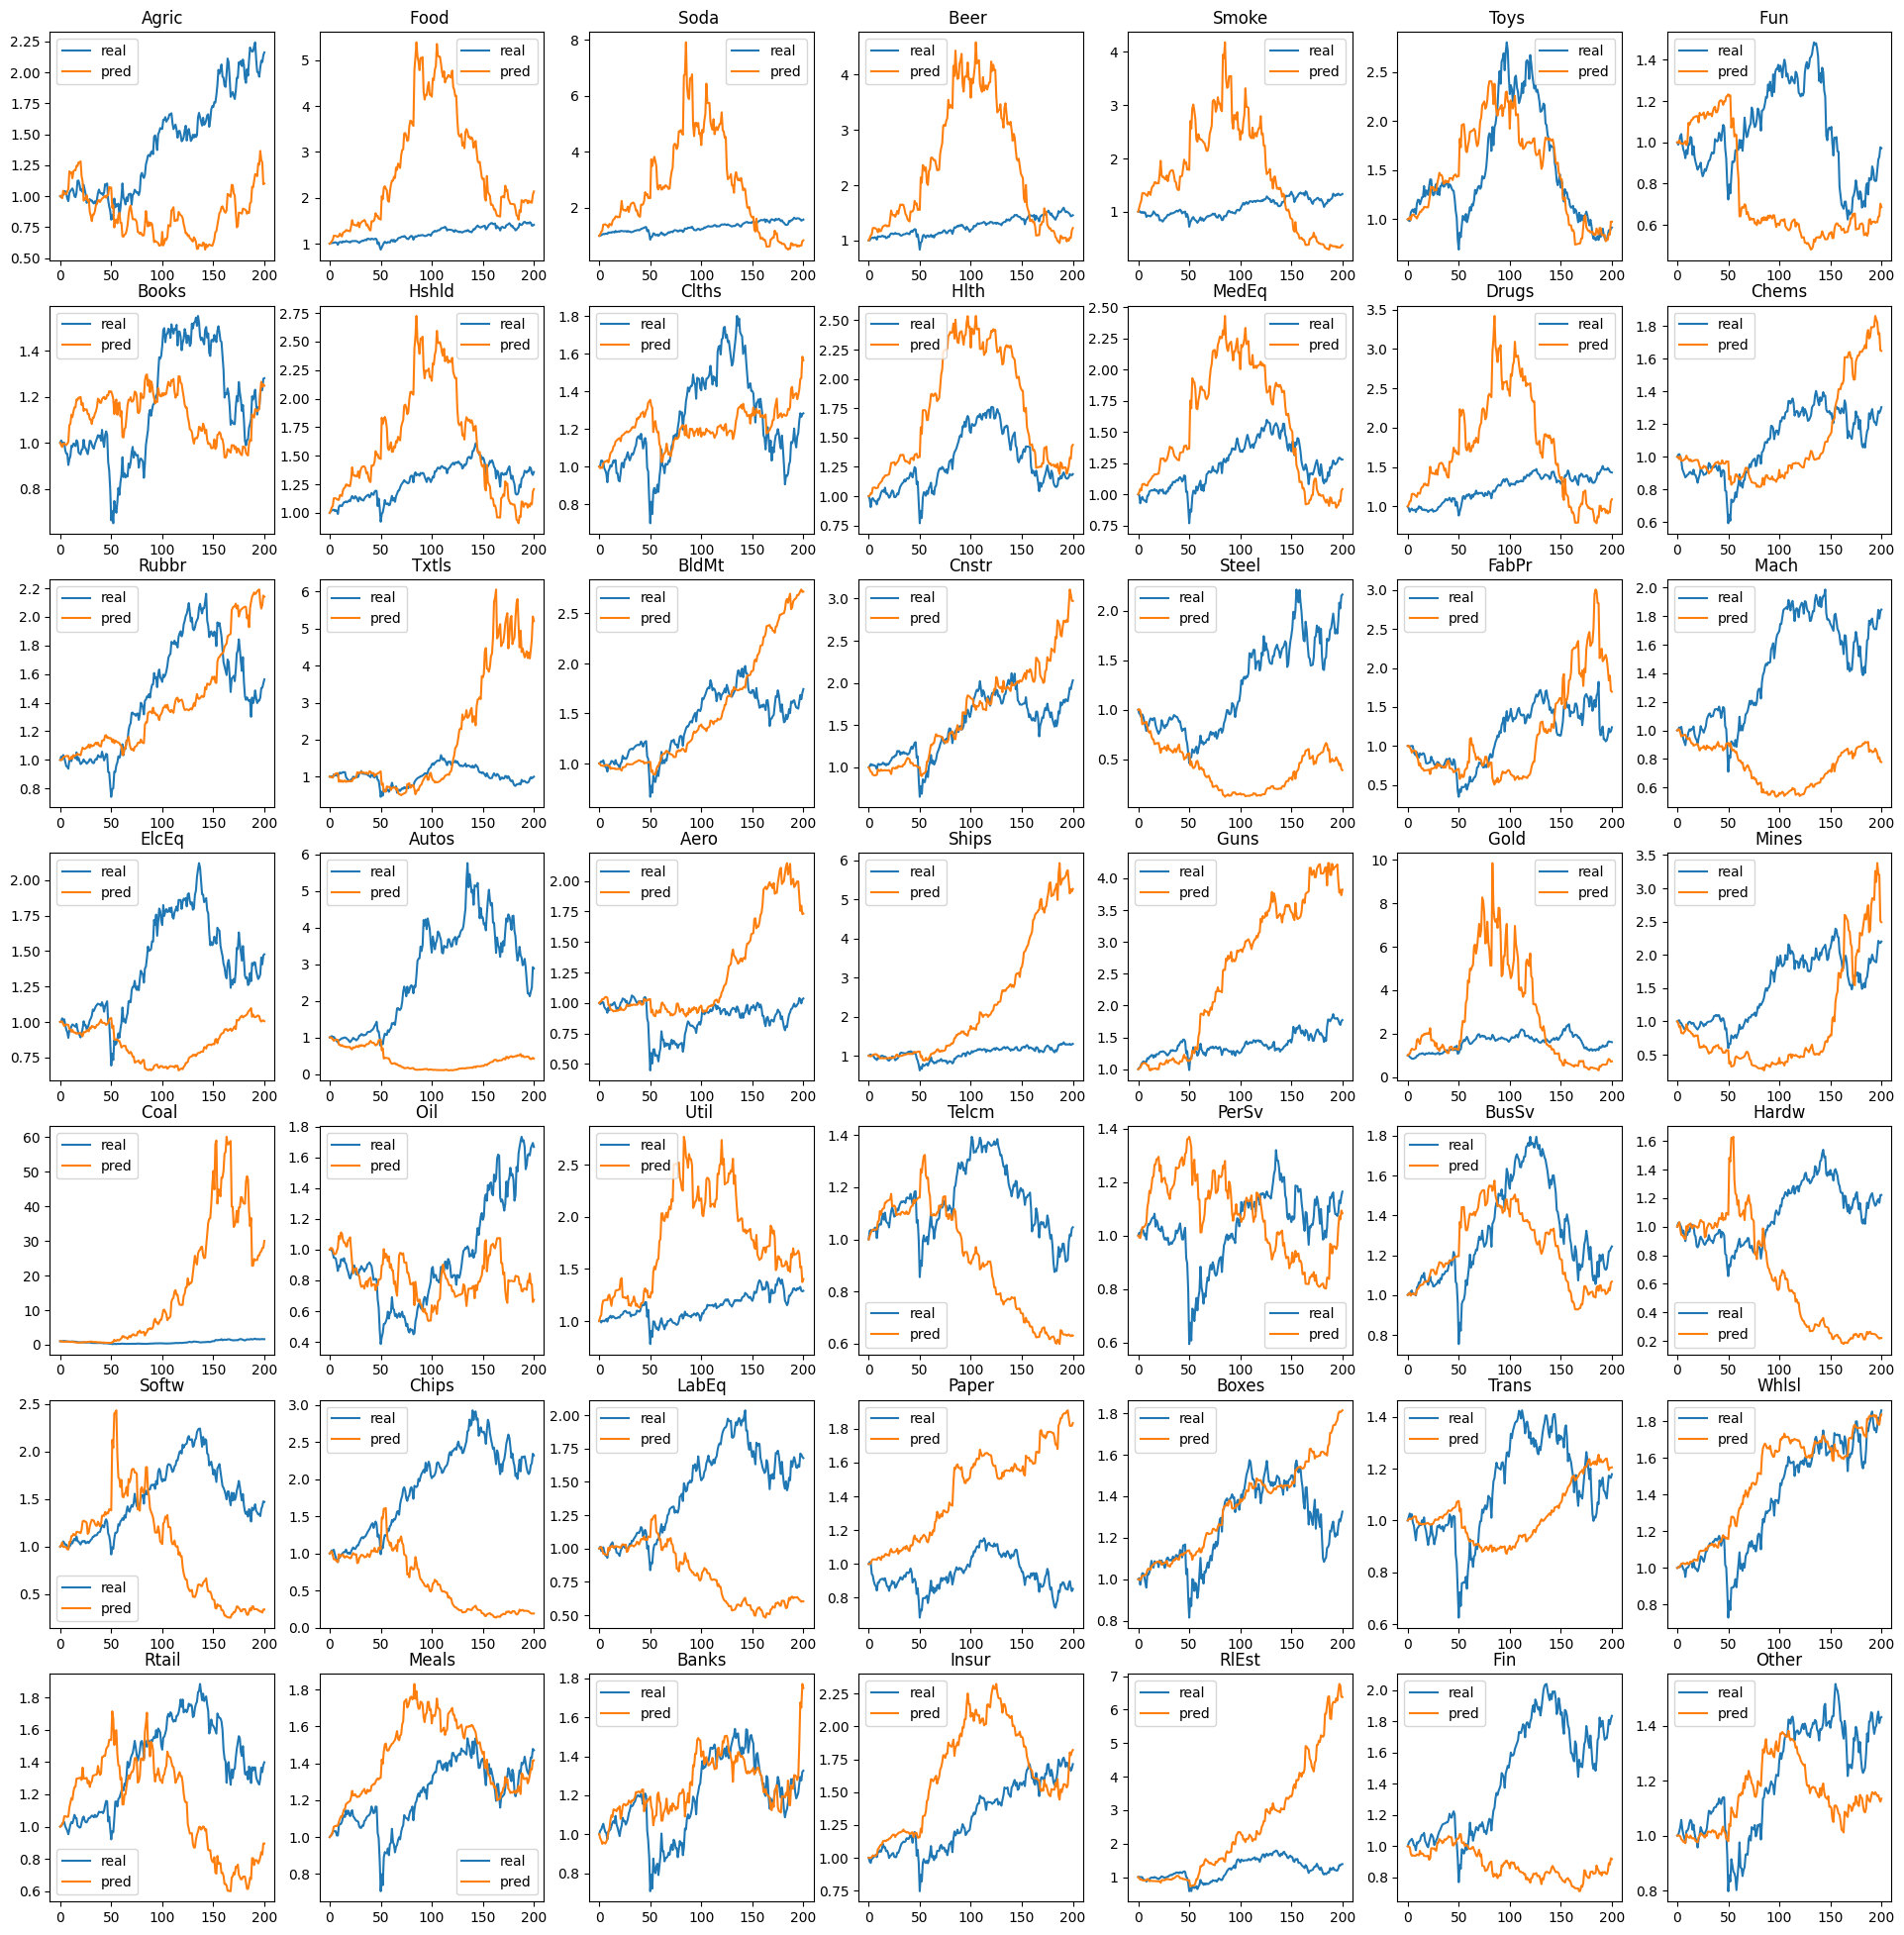

In [3]:
n_from = -200
fig, axs = plt.subplots(7, 7, figsize=(24, 16))
for i in range(N_COL):
    pred_price = calc_price(rtn_EFB[:, i][n_from:])
    real_price = calc_price(rtn_R[:, i][n_from:])

    ax = axs[i//7, i%7] # index the correct subplot
    ax.plot(real_price, label='real')
    ax.plot(pred_price, label='pred')
    ax.legend()
    ax.set_title(idx2sym[i])

plt.subplots_adjust(bottom=-0.3)
plt.show()